# CV Chain Test for Capstone Project
##### - Rishik Tiwari (techyrishik@gmail.com)

In [1]:
# import some common libraries
import json
import pickle
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time
import PIL
from PIL import Image

# llm stuff
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from llama_cpp import Llama

# fastsam
from fastsam import FastSAM, FastSAMPrompt

In [2]:
# Check that MPS is available
device = torch.device("mps")
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ and/or you do not have an MPS-enabled device on this machine.")

else:
    print('MPS is available and active!')
    device = torch.device("mps")

torch.set_default_device(device)

MPS is available and active!


In [ ]:
llmModelPath = '/Volumes/Rishik T7_1/AI/mistralChatbot/models/llama2/llama-2-7b-chat.Q4_K_M.gguf'
llm = Llama(
    model_path=llmModelPath,
    n_gpu_layers=-1,
    temperature=0.5,
    top_k=40,
    top_p=0,
    repeat_penalty=1.1764705882352942,
    n_batch=1024,
    n_ctx=1024,
    chat_format='llama-2'
)

In [77]:
samModel = FastSAM('./fastsamWeights/FastSAM-x.pt')
# samModel = FastSAM('./fastsamWeights/FastSAM-s.pt')

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [5]:
rgbVid = cv.VideoCapture('./media/pickPlaceTask_ball_zdiff--rgb.mp4')
# depthVid = cv.VideoCapture('./media/pickPlaceTask_ball_zdiff--depth.mp4')
depthVid = None
with open('./media/pickPlaceTask_ball_zdiff--depth.pkl', 'rb') as fileHandle:
    depthVid = pickle.load(fileHandle, encoding='latin1')

print(f'Total frames rgb: {rgbVid.get(cv.CAP_PROP_FRAME_COUNT)}, depth: {len(depthVid)}')

Total frames rgb: 1101.0, depth: 1171


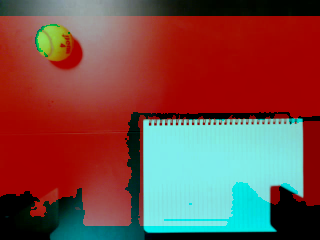

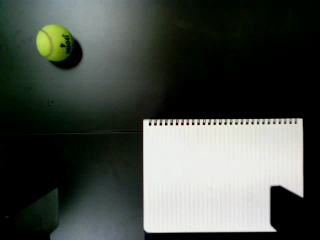

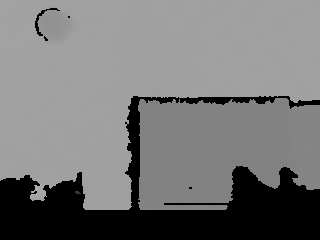

In [83]:
frameNumber = 50

rgbVid.set(cv.CAP_PROP_POS_FRAMES, frameNumber-1)
# depthVid.set(cv.CAP_PROP_POS_FRAMES, frameNumber-1)

(rgbFlag, rgbFrame) = rgbVid.read()
# (depthFlag, depthFrame) = depthVid.read()
depthFrame = depthVid[frameNumber-12] # offset for approx time shift

depthFrameNormalised = np.nan_to_num(depthFrame, copy=True, nan=0.0, posinf=1.0, neginf=0.0)
depthFrameNormalised = (depthFrameNormalised * 255).round().astype(np.uint8)

# reshape from WxH to WxHxC
depthFrameNormalised = np.reshape(depthFrameNormalised, (depthFrameNormalised.shape[0], depthFrameNormalised.shape[1], 1))

rgbFrameImg = None
depthFrameImg = None
depthYOffset = 16 # y-offset to align depth image

if rgbFlag:
    rgbFrame = cv.resize(rgbFrame, (320, 240))
    # depthFrame = cv.resize(depthFrame, (320, 240))
    rgbFrameImg = Image.fromarray(rgbFrame[:,:,::-1], mode='RGB') #BGR to RGB
    depthFrameImg = Image.fromarray(depthFrameNormalised[:,:,0], mode='L')
    
    overlayed = rgbFrame[:,:,::-1].copy()
    overlayed[depthYOffset:overlayed.shape[0], :, 0] = depthFrameNormalised[:depthFrameNormalised.shape[0]-depthYOffset, :, 0]
    overlayImg = Image.fromarray(overlayed)
    
    display(overlayImg, rgbFrameImg, depthFrameImg)
else:
    print('Could not extract video frame!')


In [ ]:
#run llm inference - Llama CPP
def inferTask(taskMsg):
    systemInstruct = '''
    Your job is to extract action and objects from the given task. Respond only in JSON format.
    \nDo not comment, explain, or elaborate your thought processes. Your response should have two keys: actions and objects. Split the task in as many as sub-actions possible. Only mention the name of object.
    \n
    \nExample 1:
    \nTask: Pick up the cookie and place it on the tiffin box.
    \nAnswer: { "actions": ["pick_up", "place"], objects: ["cookie", "tiffin box"] }
    '''
    userMsg = 'Task: ' + str.strip(taskMsg)

    llmOutput = llm.create_chat_completion(
        messages = [
            {"role": "system", "content": systemInstruct},
            {
                "role": "user",
                "content": userMsg
            }
        ],
        # stop=["<|endoftext|>"]
    )

    return str.strip(llmOutput['choices'][0]['message']['content'])

In [ ]:
def getLlmIntel(taskMsg: str):
    isSatisfiableLlmOutput = False
    llmAttemptCounter = 0
    llmIntel = None

    while ((isSatisfiableLlmOutput == False) or (llmAttemptCounter == 5)):
        llmAttemptCounter += 1
        llmIntel = inferTask(taskMsg)
        if llmIntel:
            try:
                llmIntel = json.loads(llmIntel)
                isSatisfiableLlmOutput = True
                break
            except: pass

    if not isSatisfiableLlmOutput:
        print('Could not get a satisfiable answer from llm.')
        llmIntel = {"actions": False}

    print(f'Got LLM intel in {llmAttemptCounter} attempts.')
    print(llmIntel)
    return llmIntel

In [ ]:
llmIntel = getLlmIntel('Pickup the ball and place it on the white paper')

### Loading and passing to FastSAM

In [84]:
BOX_TRESHOLD = 0.4

samInit = samModel(rgbFrame[:,:,::-1], device=device, imgsz=320, conf=BOX_TRESHOLD, iou=0.9) # iou - intersection over union
samPromptPipe = FastSAMPrompt(rgbFrame[:,:,::-1], samInit, device=device)

0: 256x320 6 objects, 40.7ms
Speed: 2.1ms preprocess, 40.7ms inference, 23.2ms postprocess per image at shape (1, 3, 320, 320)


In [85]:
TEXT_PROMPT = 'ball'
# TEXT_PROMPT = ' . '.join(llmIntel['objects']) + ' .' # all llmIntel objects are joined by dot

start_time = time.perf_counter()
# ann = prompt_process.everything_prompt()
# ann = prompt_process.box_prompt(bbox=bbox) # takes ~40ms
ann = samPromptPipe.text_prompt(text=TEXT_PROMPT) # takes ~3s, TODO: use llmIntel
end_time = time.perf_counter()

print('inference time %.2fms' % ((end_time-start_time)*1000))
print(ann.shape)

inference time 1792.79ms
(1, 256, 320)


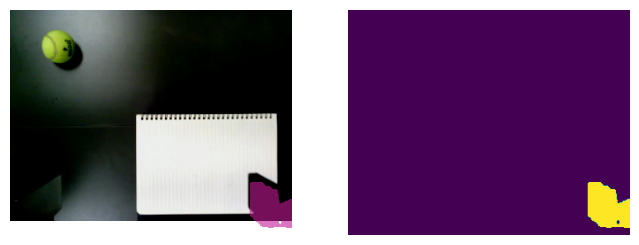

In [86]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(rgbFrame[:,:,::-1])
show_mask(ann, plt.gca(), True)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ann[0, : , :])
plt.axis('off')
plt.show()

In [ ]:
# exaggeratedDepthImg = np.asarray(depthFrameImg)*10
# cv.normalize(exaggeratedDepthImg, exaggeratedDepthImg, 0, 255, cv.NORM_MINMAX)

depthFrameNormAligned = np.zeros_like(depthFrameNormalised)
depthFrameNormAligned[depthYOffset:depthFrameNormAligned.shape[0], :, 0] = depthFrameNormalised[:depthFrameNormalised.shape[0]-depthYOffset, :, 0]

annotated_dino_depthframe = annotate(image_source=depthFrameNormAligned, boxes=dino_boxes, logits=dino_logits, phrases=dino_phrases)

# show annotated image, convert BGR to RGB by reversing the order
Image.fromarray(annotated_dino_depthframe[:,:,::-1], mode="RGB")

In [ ]:
(h, w) = rgbImg_source.shape[:2]

# the boxes value is in format: cxcywh - box center x, center y, width, height
normalised_bboxes = np.round(np.array(dino_boxes * torch.Tensor([w, h, w, h]), dtype=np.uint8), decimals=0)
print(normalised_bboxes)

In [ ]:
mean_depths = []
mid_depths = []
GRIPPER_LENGTH_CM = 22.5

for i in range(len(normalised_bboxes)):
    (cx, cy, w, h) = normalised_bboxes[i][:]
    cy -= depthYOffset      # shifts detection center by yOffset to align correctly
    w = w//2
    h = h//2
    mean_depth = np.array(depthFrame[cy-h:cy+h, cx-w:cx+w]).copy()
    mean_depth = mean_depth[~np.isnan(mean_depth)]
    mean_depth = np.mean(mean_depth) * 100 - GRIPPER_LENGTH_CM
    mean_depths.append(mean_depth)
    mid_depth = depthFrame[cy, cx] * 100 - GRIPPER_LENGTH_CM
    mid_depths.append(mid_depth)
    print('Object: %s, Mid: %.1fcm, Mean: %.1fcm' % (dino_phrases[i], mid_depth, mean_depth))
    display(Image.fromarray(depthFrameNormalised[cy-h:cy+h, cx-w:cx+w, 0]))

In [ ]:
print(mid_depths)

In [ ]:
def objDistTest(img, bbox):
    (cx, cy, bw, bh) = bbox[:]
    img = img.copy()
    colour = (0, 255, 0)
    (h, w, _) = img.shape
    tolPx = 30

    print(h, w)
    mx = (h//4)*3   # shift mid point to lower half near the gripper
    my = w//2

    cv.line(img, (0, mx), (w, mx), colour, 1) # horz
    cv.line(img, (my, 0), (my, h), colour, 1) # vert

    cv.rectangle(img, (my-tolPx, mx-tolPx), (my+tolPx, mx+tolPx), color=(0,255,255), thickness=1) # tolerance region
    cv.circle(img, (my, mx), radius=5, color=(255,0,255), thickness=-1) # required mid point

    stepx = 0
    stepy = 0
    stepz = 0

    if(cx > mx):
        stepx = 0.05
    elif(cx < mx):
        stepx = -0.05
    
    if(cy > my):
        stepy = -0.05
    elif(cy < my):
        stepy = 0.05

    print(stepx, stepy, stepz)

    return img

display(Image.fromarray( objDistTest(rgbImg_source, normalised_bboxes[0]) ))

In [ ]:
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    img = img.copy()
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

In [ ]:
display(Image.fromarray(draw_grid(rgbFrame, (10,10))))

In [ ]:
def drawARGrid(img, distance):
    img = img.copy()
    h, w, _ = img.shape
    colour = (0,255,0)

    line1X = round((w/2) - (w/4) + distance, ndigits=None)
    line2X = round((w/2) + (w/4) - distance, ndigits=None)
    line3Y = round((h/2) - (h/4) + distance, ndigits=None)
    line4Y = round((h/2) + (h/4) - distance, ndigits=None)
    
    cv.line(img, (line1X, 0), (line1X, h), colour, 1)
    cv.line(img, (line2X, 0), (line2X, h), colour, 1)
    cv.line(img, (0, line3Y), (w, line3Y), colour, 1)
    cv.line(img, (0, line4Y), (w, line4Y), colour, 1)
    cv.putText(img, str(round(distance, 1))+'cm', (4, h-4), cv.FONT_HERSHEY_PLAIN, 1, colour, 1)

    return img


In [ ]:
display(Image.fromarray(drawARGrid(rgbFrame, 20.27638)))

In [ ]:
# experimenting with superimposing and tracking a grid based on depth
cv.namedWindow('rgb')
cv.setWindowProperty('rgb', cv.WND_PROP_TOPMOST, 1)

for i in range(200, 300):
    rgbVid.set(cv.CAP_PROP_POS_FRAMES, i-1)
    # depthVid.set(cv.CAP_PROP_POS_FRAMES, i-1)

    (rgbFlag, rgbFrame) = rgbVid.read()
    # (depthFlag, depthFrame) = depthVid.read()

    if rgbFlag:
        rgbFrame = cv.resize(rgbFrame, (320, 240))
        # depthFrame = cv.resize(depthFrame, (320, 240))
        # dist = round(np.mean((depthFrame**5)*10), ndigits=None) + 1
        dist = depthVid[i][160][120]*100 - 22.5
        # print(dist)
        # gridFrame = draw_grid(rgbFrame, (dist, dist))
        gridFrame = drawARGrid(rgbFrame, dist)
        
        cv.imshow('rgb', gridFrame)
        cv.waitKey(1)
    time.sleep(0.033)

cv.destroyAllWindows()
cv.waitKey(1)